<a href="https://colab.research.google.com/github/Nuranisah05/Machine_Learning_2025/blob/main/Latihan11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install folium
!pip install contextily

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import contextily as ctx
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import from_wkt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
path = "/content/gdrive/MyDrive/PRAKTIKUM ML/Praktikum11"

In [6]:
# Memanggil dan mencetak dataset
df = pd.read_csv(path + '/data/dataset-wisata-jogja-sekitar.csv')
df.head()

,no,nama,type,vote_average,vote_count,htm_weekday,htm_weekend,latitude,longitude,image,description
0,9,Candi Borobudur,Budaya_Dan_Sejarah,4.7,81922,50000,50000,-7.607087,110.203623,https://res.cloudinary.com/dfciqrwpe/image/upl...,candi yang pernah masuk sebagai salah satu dar...
1,10,Candi Prambanan,Budaya_Dan_Sejarah,4.7,71751,50000,50000,-7.751835,110.491532,https://res.cloudinary.com/dfciqrwpe/image/upl...,candi prambanan adalah kompleks candi hindu te...
2,24,Tebing Breksi,Alam,4.4,51431,10000,10000,-7.781477,110.504576,https://res.cloudinary.com/dfciqrwpe/image/upl...,tebing breksi merupakan tempat wisata yang ber...
3,343,Gembira Loka Zoo,Buatan,4.5,36337,20000,25000,-7.806234,110.396798,https://res.cloudinary.com/dfciqrwpe/image/upl...,gambira loka adalah kebun binatang yang berada...
4,346,The Palace of Yogyakarta (Keraton Yogyakarta),Budaya_Dan_Sejarah,4.6,30091,8000,8000,-7.805284,110.364203,https://res.cloudinary.com/dfciqrwpe/image/upl...,kompleks keraton merupakan museum yang menyimp...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   no            476 non-null    int64  
 1   nama          476 non-null    object 
 2   type          476 non-null    object 
 3   vote_average  476 non-null    float64
 4   vote_count    476 non-null    int64  
 5   htm_weekday   476 non-null    int64  
 6   htm_weekend   476 non-null    int64  
 7   latitude      476 non-null    float64
 8   longitude     476 non-null    float64
 9   image         476 non-null    object 
 10  description   476 non-null    object 
dtypes: float64(3), int64(4), object(4)
memory usage: 41.0+ KB


In [8]:
#Mengecek Missing Value
df.isnull().sum()

,0
no,0
nama,0
type,0
vote_average,0
vote_count,0
htm_weekday,0
htm_weekend,0
latitude,0
longitude,0
image,0


In [9]:
# Mengecek Duplicate
df.duplicated().sum()

np.int64(0)

In [10]:
# Convert latitude & longitude ke numerik
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# Drop data tanpa koordinat
df_cleaned = df.dropna(subset=['latitude', 'longitude', 'vote_average']).copy()

# Peta dasar Jogja & sekitarnya
peta_jogja = folium.Map(
    location=[-7.7956, 110.3695],  # Titik tengah Yogyakarta
    zoom_start=10
)

# Data heatmap: [lat, long, nilai]
data_heatmap = df_cleaned[['latitude', 'longitude', 'vote_average']].values.tolist()

# Tambahkan heatmap
HeatMap(
    data_heatmap,
    radius=15,
    blur=18,
    max_zoom=14
).add_to(peta_jogja)

# Tampilkan peta
peta_jogja

In [11]:
# Jitter + Konversi ke GeoDataFrame
df_jogja = df_cleaned.copy()  # data sudah bersih & numerik

# Jitter koordinat agar tidak tumpang tindih
np.random.seed(42)

df_jogja['latitude_jitter'] = df_jogja['latitude'] + np.random.uniform(
    -0.005, 0.005, size=len(df_jogja)
)

df_jogja['longitude_jitter'] = df_jogja['longitude'] + np.random.uniform(
    -0.005, 0.005, size=len(df_jogja)
)

# Konversi ke GeoDataFrame
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    df_jogja,
    geometry=gpd.points_from_xy(
        df_jogja.longitude_jitter,
        df_jogja.latitude_jitter
    ),
    crs="EPSG:4326"
)

# Proyeksi ke Web Mercator (WAJIB untuk basemap)
gdf = gdf.to_crs(epsg=3857)

# Top 5 & Bottom 5
presentaseLokasiWisata = df.groupby("type")["vote_average"].mean()
top_5 = presentaseLokasiWisata.sort_values(ascending=False).head(5)
bottom_5 = presentaseLokasiWisata.sort_values(ascending=True).head(5)

top_5, bottom_5


(type
 Seni                  5.000000
 Kuliner               4.700000
 Agrowisata            4.525714
 Museum                4.518182
 Budaya_Dan_Sejarah    4.503540
 Name: vote_average, dtype: float64,
 type
 Minat Khusus    4.100000
 Wisata Air      4.325000
 Desa Wisata     4.340000
 Pantai          4.345098
 Pendidikan      4.350000
 Name: vote_average, dtype: float64)

(np.float64(12230768.680368623),
 np.float64(12328936.24737946),
 np.float64(-919371.406965473),
 np.float64(-841040.240401321))

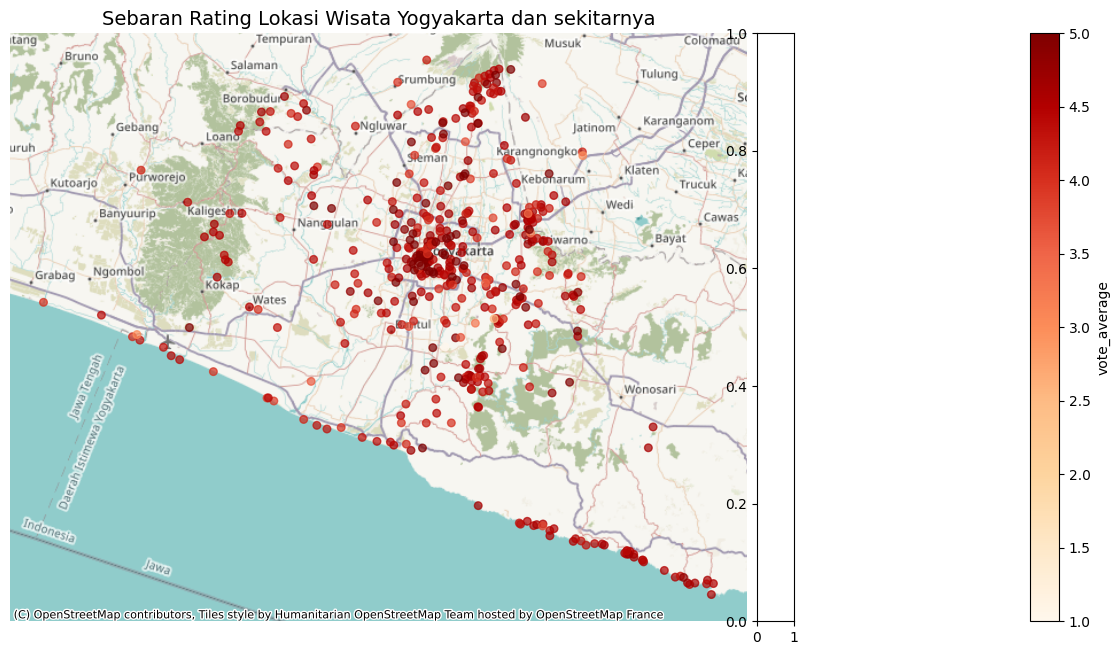

In [41]:
# Peta sebaran lokasi wisata Jogja & sekitarnya
from matplotlib import gridspec
# Visualisasi peta dan grafik bar

#Buat layout dengan GridSpec
fig = plt.figure(figsize=(18, 14))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 2] )

# -- Row 1: Peta sebaran --
ax_map = plt.subplot(gs[0, :])
divider = make_axes_locatable(ax_map)
cax = divider.append_axes("right", size="5%", pad=0.1)

gdf.plot(
    ax=ax_map,
    column='vote_average',
    cmap='OrRd',
    markersize=30,
    alpha=0.7,
    legend=True,
    legend_kwds={'label': "vote_average", 'orientation': "vertical"}
)

ctx.add_basemap(ax_map)
ax_map.set_title(
    "Sebaran Rating Lokasi Wisata Yogyakarta dan sekitarnya",
    fontsize=14
)
ax_map.axis('off')

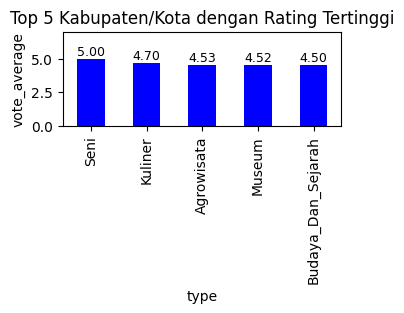

In [13]:
# -- Row 2: Bar chart top & bottom --
ax_top = plt.subplot(gs[1, 1])
bars_top = top_5.plot(kind='bar', ax=ax_top, color='blue')
ax_top.set_title('Top 5 Kabupaten/Kota dengan Rating Tertinggi')
ax_top.set_ylabel('vote_average')
ax_top.set_xlabel('type')
# ax.tick_params(axis='x', rotation=90)
ax_top.tick_params(axis='x', rotation=90)

# Tambahkan anotasi
for i, val in enumerate(top_5):
    ax_top.text(i, val + 1, f"{val:.2f}", ha='center', va='top', fontsize=9)

# Sinkronisasi skala y kedua chart
max_val = max(top_5.max(), bottom_5.max())
ax_top.set_ylim(0, max_val + 2)
# ax_bottom.set_ylim(0, max_val + 1)

plt.tight_layout()
plt.show()

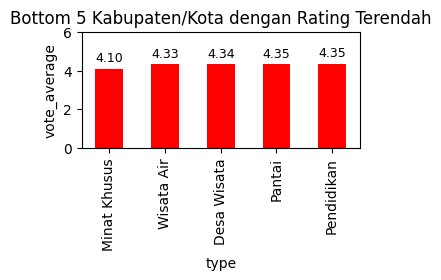

In [14]:

# -- Row 3: Bar chart for bottom 5 --
ax_bottom = plt.subplot(gs[1, 1])
bars_bottom = bottom_5.plot(kind='bar', ax=ax_bottom, color='red')
ax_bottom.set_title('Bottom 5 Kabupaten/Kota dengan Rating Terendah')
ax_bottom.set_ylabel('vote_average')
ax_bottom.set_xlabel('type')
ax_bottom.tick_params(axis='x', rotation=90)

# Tambahkan anotasi
for i, val in enumerate(bottom_5):
    ax_bottom.text(i, val + 0.2, f"{val:.2f}", ha='center', va='bottom', fontsize=9)

# Sinkronisasi skala y kedua chart
max_val = max(top_5.max(), bottom_5.max())
ax_top.set_ylim(0, max_val + 1)
ax_bottom.set_ylim(0, max_val + 1)

plt.tight_layout()
plt.show()

In [15]:
# Visualisasi rata-rata rating lokasi wisata per tipe yogyakarta
df.columns

Index(['no', 'nama', 'type', 'vote_average', 'vote_count', 'htm_weekday',
       'htm_weekend', 'latitude', 'longitude', 'image', 'description'],
      dtype='object')

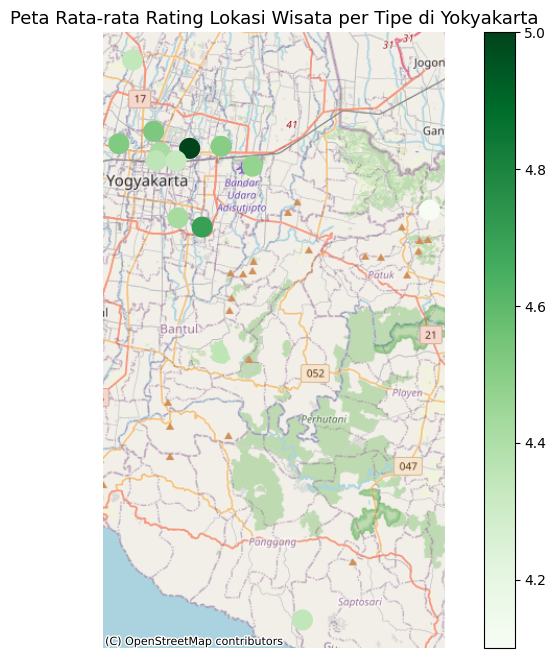

In [31]:
# Hitung rata-rata rating per tipe
avg_rating_typ = (
    df_jogja
    .groupby('type')['vote_average']
    .mean()
    .reset_index()
)

# Mengambil koordinat representatif per tipe
koord_kab = (
    df_jogja
    .groupby('type')[['latitude', 'longitude']]
    .mean()
    .reset_index()
)

# Menggabungkan data
map_rating = avg_rating_typ.merge(
    koord_kab, on='type'
)

# Konversi ke GeoDataFrame
gdf_rating = gpd.GeoDataFrame(
    map_rating,
    geometry=gpd.points_from_xy(
        map_rating.longitude,
        map_rating.latitude
    ),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Visualisasi peta
fig, ax = plt.subplots(figsize=(10,8))

gdf_rating.plot(
    ax=ax,
    column='vote_average',
    cmap='Greens',
    markersize=200,
    legend=True
)

import contextily as ctx
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title(
    "Peta Rata-rata Rating Lokasi Wisata per Tipe di Yokyakarta",
    fontsize=13
)

ax.axis('off')
plt.show()

In [17]:
# Uji Normalitas
from scipy.stats import shapiro

# Hapus semua kolom bertipe float64
normalityTest_df = df.drop(columns=[
    'nama',
    'type',
    'image',
    'description'
    ], errors='ignore')

# Cek struktur data hasil
normalityTest_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   no            476 non-null    int64  
 1   vote_average  476 non-null    float64
 2   vote_count    476 non-null    int64  
 3   htm_weekday   476 non-null    int64  
 4   htm_weekend   476 non-null    int64  
 5   latitude      476 non-null    float64
 6   longitude     476 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 26.2 KB


In [18]:
# Menampilkan DataFrame baru
stat, p = shapiro(normalityTest_df['vote_average'])

print("Statik: ", stat)
print("P-value: ", p)

if p > 0.05:
	print('Data berdistribusi normal (tidak tolak H0)')
else:
	print('Data berdistribusi non normal (tolak H0)')

Statik:  0.7727203469381945
P-value:  3.695840328661176e-25
Data berdistribusi non normal (tolak H0)


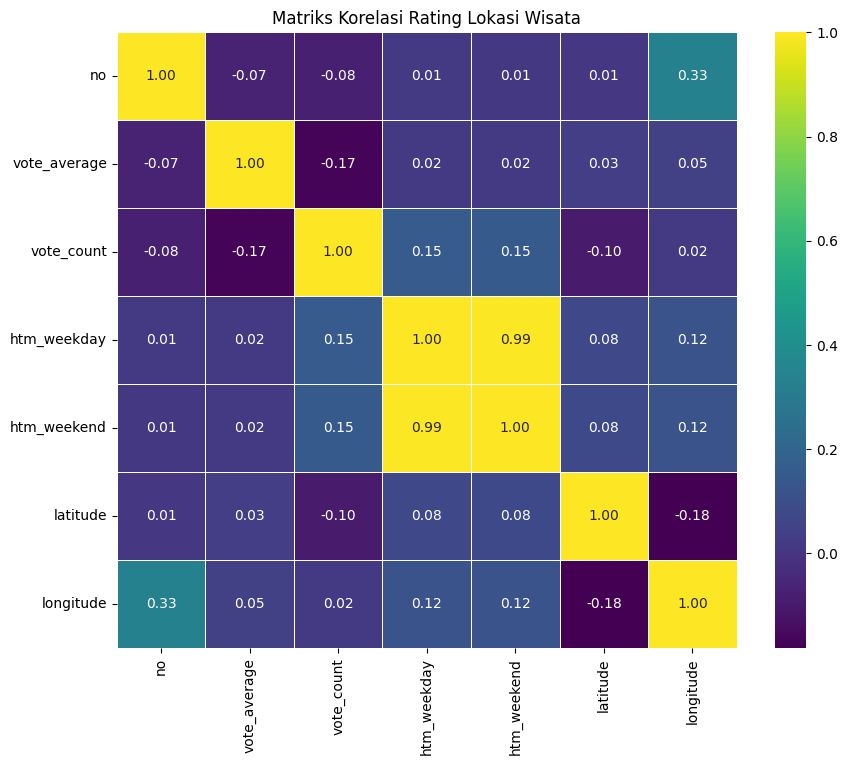

In [19]:
# Analisis Matriks Korelasi
correlation_df = normalityTest_df.select_dtypes(include=[np.number])

correlation_matrix = correlation_df.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=0.5
)
plt.title('Matriks Korelasi Rating Lokasi Wisata')
plt.show()

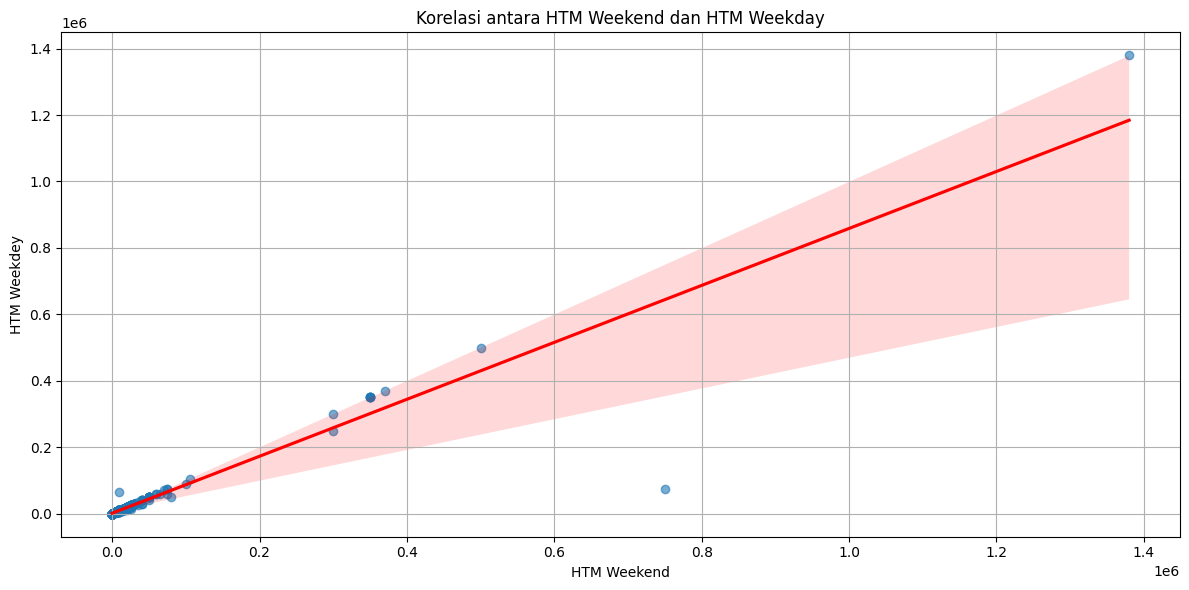

In [20]:
# Anaalisis korelasi spesifik: htm_weekend vs htm_weekday
plt.figure(figsize=(12,6))
sns.regplot(
    x="htm_weekend",
    y="htm_weekday",
    data=df,
    scatter_kws={'alpha':0.6},
    line_kws={"color": "red"}
)

plt.title('Korelasi antara HTM Weekend dan HTM Weekday')
plt.xlabel('HTM Weekend')
plt.ylabel('HTM Weekdey')
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
#Normalisasi data

# Pemilihan Kolom untuk Normalisasi
normalisasi_df = df.drop(columns=[
    'nama',
    'type',
    'image',
    'description'
    ], errors='ignore')

normalisasi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   no            476 non-null    int64  
 1   vote_average  476 non-null    float64
 2   vote_count    476 non-null    int64  
 3   htm_weekday   476 non-null    int64  
 4   htm_weekend   476 non-null    int64  
 5   latitude      476 non-null    float64
 6   longitude     476 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 26.2 KB


In [22]:
# proses normlisasi dengan RobustScaler
from sklearn.preprocessing import RobustScaler

columns_name = normalisasi_df.columns
scaler = RobustScaler()
normalisasi_df = scaler.fit_transform(normalisasi_df)
normalisasi_df = pd.DataFrame(normalisasi_df, columns=columns_name)

normalisasi_df.head()

,no,vote_average,vote_count,htm_weekday,htm_weekend,latitude,longitude
0,-0.960552,0.666667,88.004843,3.750000,3.000000,1.533071,-1.699757
1,-0.956607,0.666667,77.059457,3.750000,3.000000,0.415369,0.809201
2,-0.901381,-0.333333,55.192359,0.416667,0.333333,0.186482,0.922871
3,0.357002,0.000000,38.949153,1.250000,1.333333,-0.004691,-0.016350
4,0.368836,0.333333,32.227603,0.250000,0.200000,0.002644,-0.300393


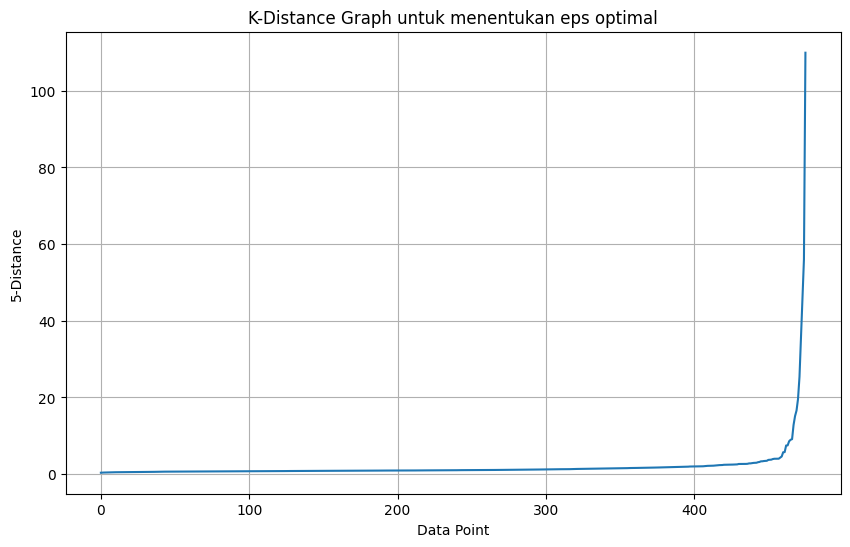

In [23]:
# Menentukan Parameter epsilon menggunakan K-Distance Graph
from sklearn import neighbors

# Gunakan data hasil normalisasi
X = normalisasi_df.values

# Tentukan jumlah tetangga (min_samples biasanya = 4-10)
k = 5

#Fit nearest neighbors
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)

# Hitung jarak tetangga terdekat
distances, indices = neighbors_fit.kneighbors(X)

# Ambil jarak tetangga ke k (K-Distance)
k_distances = np.sort(distances[:, k-1])

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title('K-Distance Graph untuk menentukan eps optimal')
plt.xlabel('Data Point')
plt.ylabel(f'{k}-Distance')
plt.grid(True)
plt.show()


In [24]:
# Clustering dengan DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=3.0, min_samples=5)
labels = dbscan.fit_predict(normalisasi_df.values)

df["Cluster_DBSCAN"] = labels
print(df["Cluster_DBSCAN"].value_counts())

Cluster_DBSCAN
 0    451
-1     25
Name: count, dtype: int64


In [25]:
# Evaluasi kualitas clustering menggunakan Silhouette Score
from sklearn.metrics import silhouette_score

from sklearn.metrics import silhouette_score
import numpy as np

mask = labels != -1
cluster_labels = np.unique(labels[mask])

if len(cluster_labels) > 1:
    score = silhouette_score(
        normalisasi_df.values[mask],
        labels[mask]
    )
    print("Silhouette Score:", score)
else:
    print(
        "Silhouette Score tidak dapat dihitung karena "
        "jumlah cluster kurang dari 2."
    )


Silhouette Score tidak dapat dihitung karena jumlah cluster kurang dari 2.


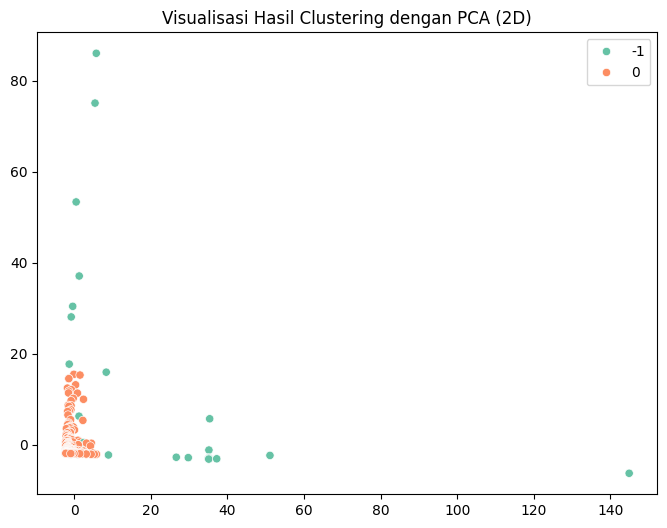

In [26]:
# Visualisasi Hasil Clustering dengan PCA (2D)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(normalisasi_df)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=reduced[:, 0],
    y=reduced[:, 1],
    hue=labels,
    palette="Set2",
)
plt.title("Visualisasi Hasil Clustering dengan PCA (2D)")
plt.show()

In [27]:
# Pengelompokan kualitas cluster
def klasifikasi_db(x):
    if x == 0:
        return "Baik"
    elif x == -1:
        return "Noise"
    else:
        return "Kurang Baik"


df["Klaseifikasi_DBSCAN"] = df["Cluster_DBSCAN"].apply(klasifikasi_db)
print(df["Klaseifikasi_DBSCAN"].value_counts())


Klaseifikasi_DBSCAN
Baik     451
Noise     25
Name: count, dtype: int64


In [28]:
# Analisis lanjutan per cluster
cluster_summary_db = df.drop(columns=[
    'no',
    'htm_weekend',
    'htm_weekday',
    'vote_count',
    'nama',
    'type',
    'image',
    'description']
  ).groupby("Klaseifikasi_DBSCAN").mean()

cluster_summary_db

,vote_average,latitude,longitude,Cluster_DBSCAN
Klaseifikasi_DBSCAN,,,,
Baik,4.46031,-7.825718,110.395494,0.0
Noise,4.18000,-7.770974,110.413369,-1.0


In [42]:
# Visualisasi Interaktif Persebaran Cluster (Plotly)
# Data untuk hover
import plotly.express as px

df_pca_db = pd.DataFrame(reduced, columns=['PCA 1', 'PCA 2'])
df_pca_db['Klaseifikasi_DBSCAN'] = df['Klaseifikasi_DBSCAN'].values
df_pca_db['type'] = df['type'].values

# Ubah label agar noise mudah dibaca
df_pca_db['Label_Cluster'] = df_pca_db['Klaseifikasi_DBSCAN'].astype(str)
df_pca_db.loc[
    df_pca_db['Klaseifikasi_DBSCAN'] == -1, 'Label_Cluster'
] = 'Noise'

# Tentukan warna (Noise abu-abu)
color_map = {'Noise': 'black'}

# Tambahkan warna otomatis untuk cluster lain
for c in df_pca_db['Label_Cluster'].unique():
    if c != 'Noise':
        color_map[c] = None  # plotly auto color

# Plot interaktif
fig = px.scatter(
    df_pca_db,
    x='PCA 1',
    y='PCA 2',
    color='Label_Cluster',
    color_discrete_map=color_map,
    hover_name='type',
    title='Sebaran Data Berdasarkan Hasil Clustering DBSCAN',
    width=1200,
    height=900
)

fig.show()
